# Gemicai tutorial 1: Intro to Gemicai

Welcome to the Gemicai introduction tutorial! In this tutorial we'll briefly touch upon some of the core functionalities of the Gemicai library.

## 1.0 Preliminaries

In [1]:
import gemicai as gem
import torch
import torchvision.models as models
from matplotlib import pyplot as plt

## 1.1 Datasets
First, we let's take a look some datasets. For this tutorial, we've already prepared a Gemicai Dataset, (or .gemset file). In the next tutorial you can learn how to create your own gemsets.

In [2]:
# With Gemicai, images can have as many labels as you want.
# Note that Modality and BodyPartExamined are Dicom attributes!
labels = ['Modality', 'BodyPartExamined']

# Load demo dataset
dataset = gem.utils.get_demo_gemset(labels)

# Summarize dataset on Modality label
dataset.summarize('Modality')

# Summarize dataset on BodyPartExamined label
dataset.summarize('BodyPartExamined')

| Class (Modality)   |   Frequency |
|--------------------+-------------|
| DX                 |         210 |

Total number of training images: 210 
Total number of classes: 1

| Class (BodyPartExamined)   |   Frequency |
|----------------------------+-------------|
| FOOT                       |         140 |
| HAND                       |          70 |

Total number of training images: 210 
Total number of classes: 2



As you can tell from these summaries, this dataset contains 210 images, some of them are images of hands, others of feet. But all images have the same modality DX.

With Gemicai you can also very easlily create subsets of datasets:

In [3]:
subset = dataset.subset(constraints={'Modality': ['DX'], 'BodyPartExamined': ['HAND']})

subset.summarize('BodyPartExamined')

| Class (BodyPartExamined)   |   Frequency |
|----------------------------+-------------|
| HAND                       |          70 |

Total number of training images: 70 
Total number of classes: 1



Gemicai also provides a bunch of built in functionality for inspecting datasets to help you select the right data. 
For example: Having trouble understanding classes in a certain dataset? plot_one_of_every will plot an image for every class of a specific label.

Modality        : DX
BodyPartExamined : FOOT
StudyDescription : Voet beiderzijds
SeriesDescription : VOET 3/4 Li



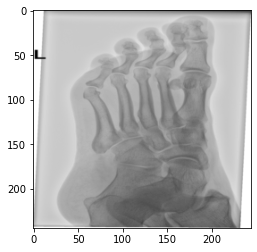

Modality        : DX
BodyPartExamined : HAND
StudyDescription : Hand links
SeriesDescription : 3/4



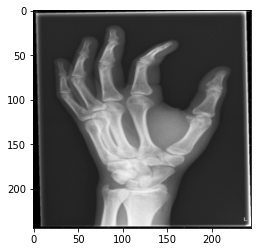

In [4]:
dataset.plot_one_of_every('BodyPartExamined')

## 1.2 Classifiers

Creating you own neural network has never been so easy, for demonstration purposes we'll build a classifier that can differentiate hands from feet. First, take a popular model from https://pytorch.org/docs/stable/torchvision/models.html (or build your own by extending PyTorch's nn.Module). To enable automatic GPU configuration set enable_cuda=True.

In [9]:
# For this example, we take resnet18
resnet18 = models.resnet18(pretrained=False)

classes = dataset.classes('BodyPartExamined')
print('Classes are: {}'.format(classes))

# All a classifier needs is a base model, and a list of classes you want to classify
net = gem.Classifier(resnet18, classes, enable_cuda=True)

Classes are: ['FOOT', 'HAND']


Now lets train the network, similar to keras, you can set verbosity to print out statistics while training.

In [10]:
net.train(dataset['BodyPartExamined'], epochs=5, verbosity=2)

| Epoch | Avg. loss | Train Acc. | Test Acc.  | Elapsed  |   ETA    |
|-------+-----------+------------+------------+----------+----------|
|     1 | 0.0971558 | 99.05%     | -          | 00:00:01 | 00:17:17 |
|     2 | 0.2523532 | 99.52%     | -          | 00:00:01 | 00:17:19 |
|     3 | 0.0999900 | 66.67%     | -          | 00:00:01 | 00:17:19 |
|     4 | 0.0346059 | 94.76%     | -          | 00:00:01 | 00:17:19 |
|     5 | 0.0110091 | 99.05%     | -          | 00:00:01 | 00:17:19 |
Training finished, total time elapsed: 0:00:00.596122



Evaluating the network is just as easy

In [11]:
net.evaluate(dataset['BodyPartExamined'], verbosity=2)

| <class 'list'> | <class 'list'> | <class 'list'> |
| Class   |   Total |   Correct | Acc    |
|---------+---------+-----------+--------|
| FOOT    |     140 |       140 | 100.0% |
| HAND    |      70 |        68 | 97.1%  | 



(99.05, 210, 208)

## 1.3 Saving and loading a classifier

Once you're done training the classifier, and want to store it away for later, you can do so using .save(file_path)

In [12]:
net.save('demo_classifier.gemclas')

del net

And to retrieve a Classifier use Classifier.load

In [13]:
net = gem.Classifier.from_file('demo_classifier.gemclas')

print(net.classes)

['FOOT', 'HAND']


## 1.4 Hyper parameter optimisation
Different loss functions, optimiziers or pretty much any hyper parameter can be easlily changed by overwriting the Classifiers attributes

In [14]:
# Try different loss function
net.loss_function = torch.nn.CrossEntropyLoss()

# Try different optimizer
net.optimizer = torch.optim.SGD(net.module.parameters(), lr=0.0001, momentum=0.9)